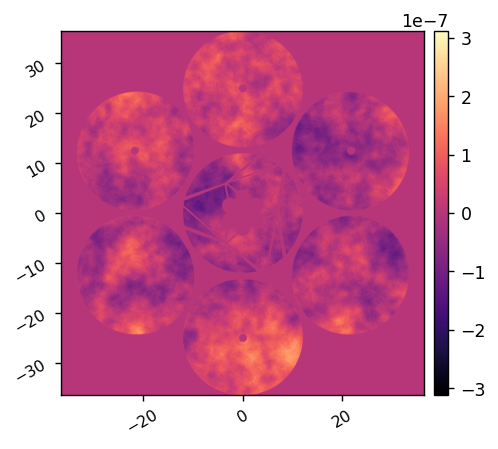

In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits

from gmagaox.math_module import xp, _scipy, ensure_np_array
import gmagaox.gmagaox as gmagaox
from gmagaox import optics, opds
from gmagaox import utils
from gmagaox.imshows import *

from importlib import reload

import poppy

import logging
import sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False
poppy_log.disabled = True

zemax_pupil_diams = {
    'fsm-pp':16.1887*u.mm,
    'ADC-pp':50.3325*u.mm, 
    'woofer-pp':87.6977*u.mm, 
    'tweeter-pp':73.7536*u.mm, 
    'focal plane SM - pp':12.1121*u.mm, 
    'Apodizer-pp':24.2002*u.mm, 
    'Lyot-pp':25.1939*u.mm, 
}

tweeter_pupil_diam = 72.88629845263029*u.mm
apodizer_pupil_diam = 23.9511421127761*u.mm
lyot_pupil_diam = 25.204568699366828*u.mm

lyot_opd = fits.getdata('gmagaox/data/lyot_opd.fits')
# lyot_opd = fits.getdata('gmagaox/data/filtered_lyot_opd.fits')
lyot_pixelscale = fits.getheader('gmagaox/data/lyot_opd.fits')['PIXELSCL'] * u.m/u.pix

tweeter_lyot_mag = (tweeter_pupil_diam/lyot_pupil_diam).decompose().value
tweeter_pixelscale = lyot_pixelscale*tweeter_lyot_mag

LYOT_WFE = poppy.ArrayOpticalElement(opd=-xp.rot90(xp.rot90(lyot_opd)), pixelscale=tweeter_pixelscale)
imshow1(LYOT_WFE.opd, pxscl=LYOT_WFE.pixelscale.to(u.mm/u.pix))

npsf = 128



# Get a Perfect PSF to estimate Strehl

In [2]:
reload(gmagaox)
reload(opds)

model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
# model.use_dm_surfaces = True

perfect_psf = utils.pad_or_crop(model.snap(), npsf)


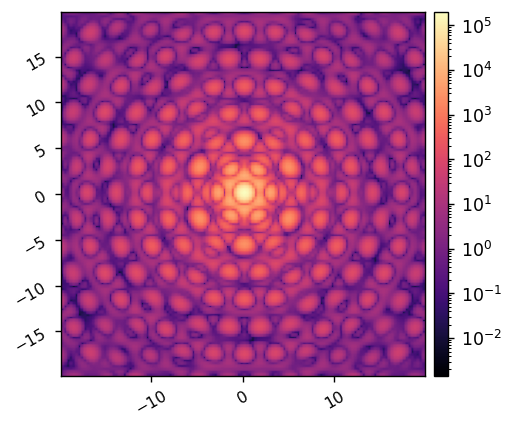

In [3]:
imshow1(perfect_psf, lognorm=True, pxscl=model.psf_pixelscale_lamD)

# Without Phase Corrections

In [3]:
reload(gmagaox)
reload(opds)

model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

aberrated_psf = utils.pad_or_crop(model.snap(), npsf)


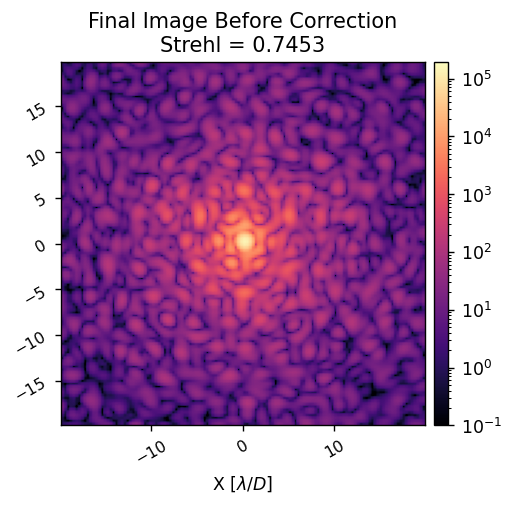

In [4]:
aberrated_strehl = xp.max(aberrated_psf)/xp.max(perfect_psf)
imshow1(aberrated_psf, f'Final Image Before Correction\nStrehl = {aberrated_strehl:.4f}',
        lognorm=True, pxscl=model.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]',
        vmax=xp.max(perfect_psf),vmin=1e-1,
        )

In [5]:
reload(gmagaox)
reload(opds)

# model = gmagaox.MODEL(npix=2540, oversample=4096/2540)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.end_at_lyot = True

lyot_wf = model.calc_wf()

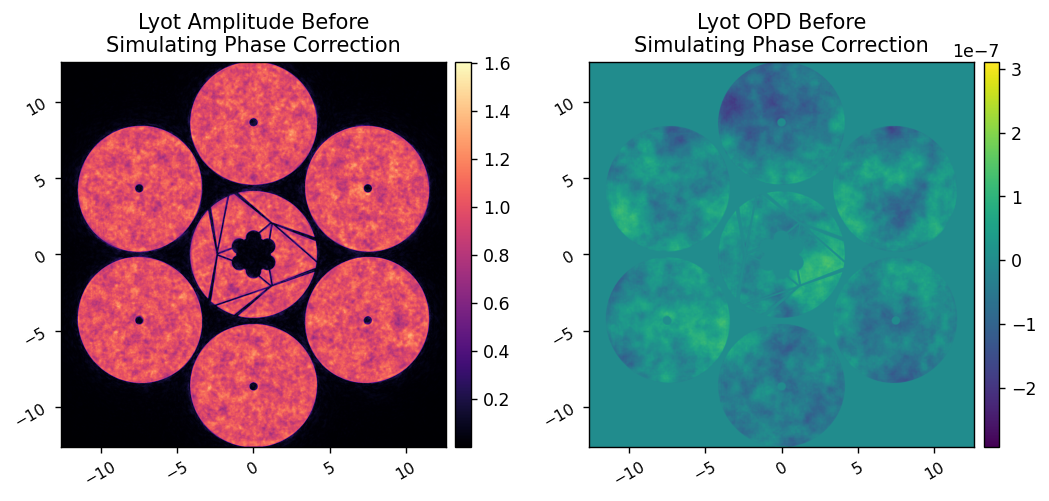

In [6]:
lyot_amp = utils.pad_or_crop(xp.abs(lyot_wf), model.npix)
lyot_phs = utils.pad_or_crop(xp.angle(lyot_wf), model.npix)

imshow2(lyot_amp, lyot_phs*model.pupil_mask*model.wavelength.to_value(u.m)/(2*np.pi), 
        'Lyot Amplitude Before\nSimulating Phase Correction',
        'Lyot OPD Before\nSimulating Phase Correction',
        cmap2='viridis', pxscl=lyot_pupil_diam/model.npix)

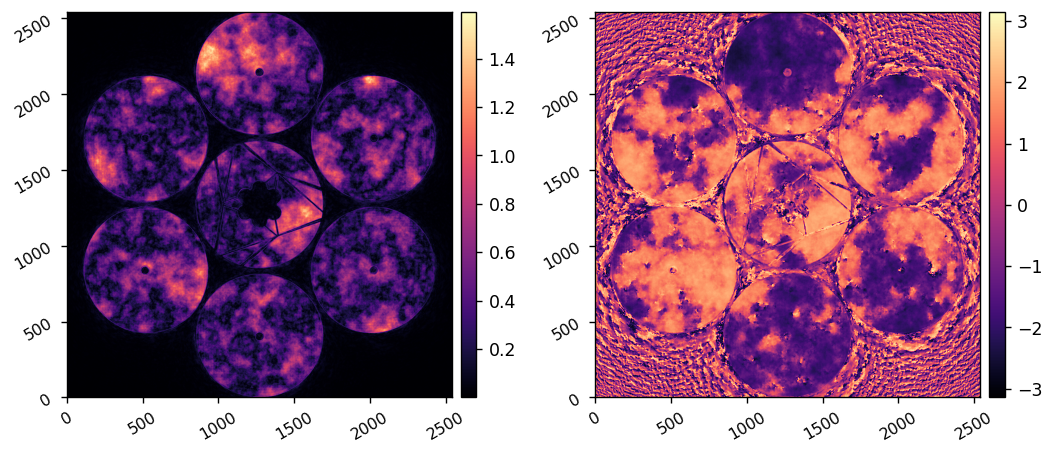

In [7]:

ideal_coro = lyot_wf - utils.pad_or_crop(model.PUPIL.amplitude, model.N)*xp.sum(lyot_wf*utils.pad_or_crop(model.PUPIL.amplitude, model.N))/xp.sum(model.PUPIL.amplitude*model.PUPIL.amplitude)
imshow2(xp.abs(ideal_coro), xp.angle(ideal_coro), npix=model.npix)

In [8]:
# apodizer_pixelscale = apodizer_pupil_diam/(model.npix*u.pix)
# apodizer = poppy.ArrayOpticalElement(transmission=xp.abs(ideal_coro), 
#                                      opd=xp.angle(ideal_coro)*model.wavelength.to_value(u.m)/(2*np.pi),
#                                      pixelscale=apodizer_pixelscale)

lyot_pixelscale = lyot_pupil_diam/(model.npix*u.pix)
LYOT = poppy.ArrayOpticalElement(transmission=xp.abs(ideal_coro), 
                                     opd=xp.angle(ideal_coro)*model.wavelength.to_value(u.m)/(2*np.pi),
                                     pixelscale=lyot_pixelscale)

In [9]:
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

# model.APODIZER = None
model.LYOT = None
raw_fp_wf = utils.pad_or_crop(model.calc_wf(), npsf)

model.Imax_ref = xp.max(xp.abs(raw_fp_wf)**2)
# model.APODIZER = apodizer
model.LYOT = LYOT
ideal_coro_fp_wf = utils.pad_or_crop(model.calc_wf(), npsf)


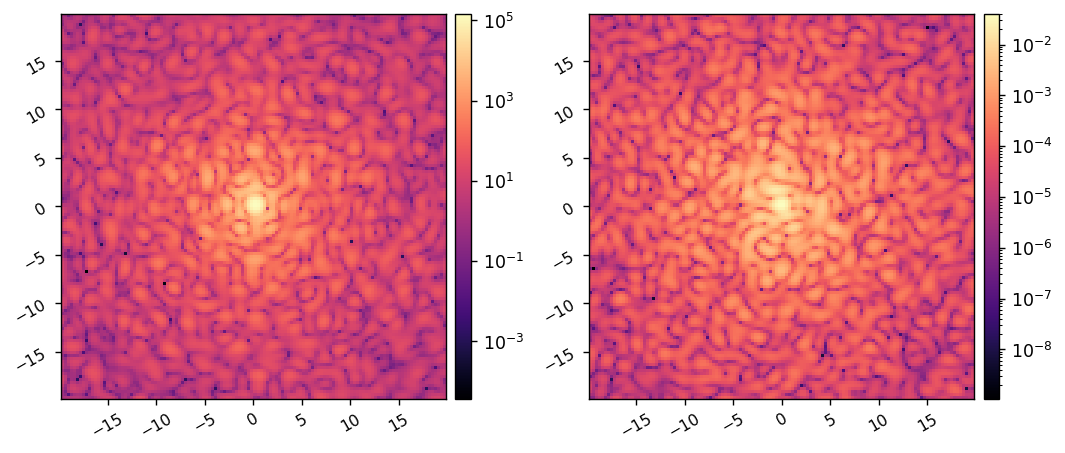

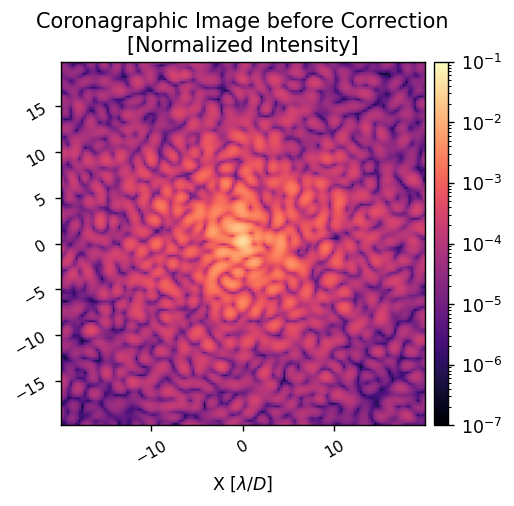

In [10]:
imshow2(xp.abs(raw_fp_wf)**2, xp.abs(ideal_coro_fp_wf)**2, 
        pxscl=model.psf_pixelscale_lamD,
        lognorm=True)

imshow1(xp.abs(ideal_coro_fp_wf)**2, 'Coronagraphic Image before Correction\n[Normalized Intensity]',
        xlabel='X [$\lambda/D$]', pxscl=model.psf_pixelscale_lamD,
        lognorm=True, vmax=1e-1, vmin=1e-7)

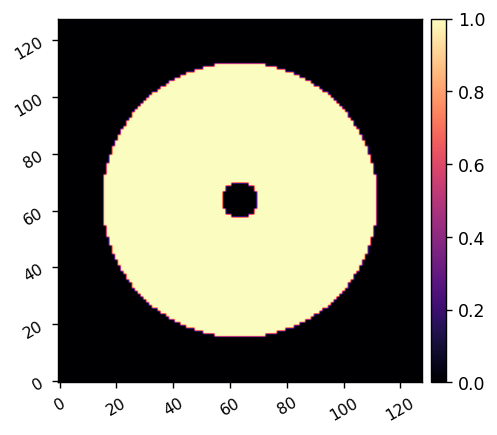

array(0.00044179)

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


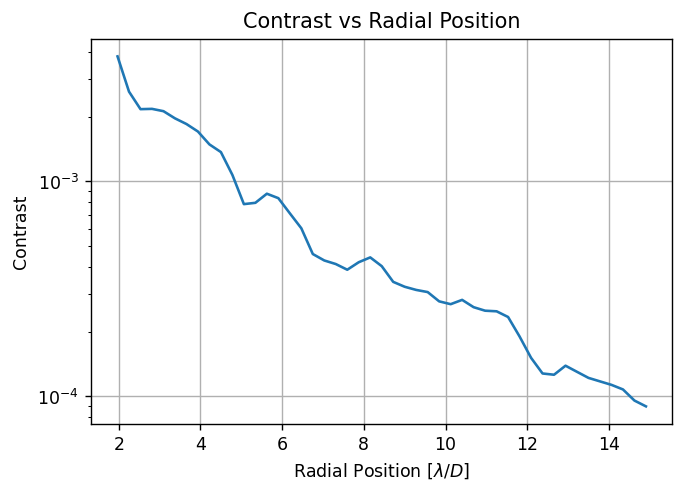

In [13]:
reload(utils)
iwa = 2
owa = 15
roi_mask = utils.create_annular_focal_plane_mask(model.psf_pixelscale_lamD, npsf, inner_radius=iwa, outer_radius=owa )
imshow1(roi_mask)

display(xp.mean((xp.abs(ideal_coro_fp_wf[roi_mask])**2)))

r, contrast = utils.plot_radial_contrast(xp.abs(ideal_coro_fp_wf)**2, 
                                        roi_mask, 
                                        pixelscale=model.psf_pixelscale_lamD, 
                                        nbins=100,
                                        return_data=True)

In [2]:
!nvidia-smi

Tue Feb 27 12:50:10 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   33C    P0             63W /  300W |   42451MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

# With Phase Corrections

In [14]:
reload(gmagaox)
reload(opds)

model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.use_lyot_opd = True
model.LYOT_WFE = LYOT_WFE

corrected_psf = utils.pad_or_crop(model.snap(), npsf)


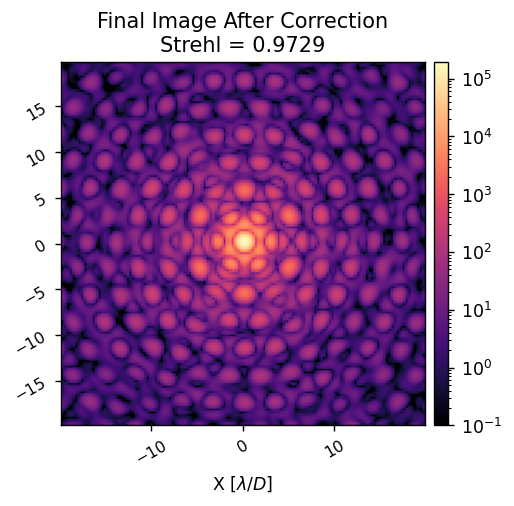

In [15]:
corrected_strehl = xp.max(corrected_psf)/xp.max(perfect_psf)
imshow1(corrected_psf, f'Final Image After Correction\nStrehl = {corrected_strehl:.4f}',
        lognorm=True, pxscl=model.psf_pixelscale_lamD, xlabel='X [$\lambda/D$]',
        vmax=xp.max(perfect_psf),vmin=1e-1,
        )

In [16]:
reload(gmagaox)
reload(opds)

# model = gmagaox.MODEL(npix=2540, oversample=4096/2540)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.use_lyot_opd = True
model.LYOT_WFE = LYOT_WFE

model.end_at_lyot = True

lyot_wf = model.calc_wf()

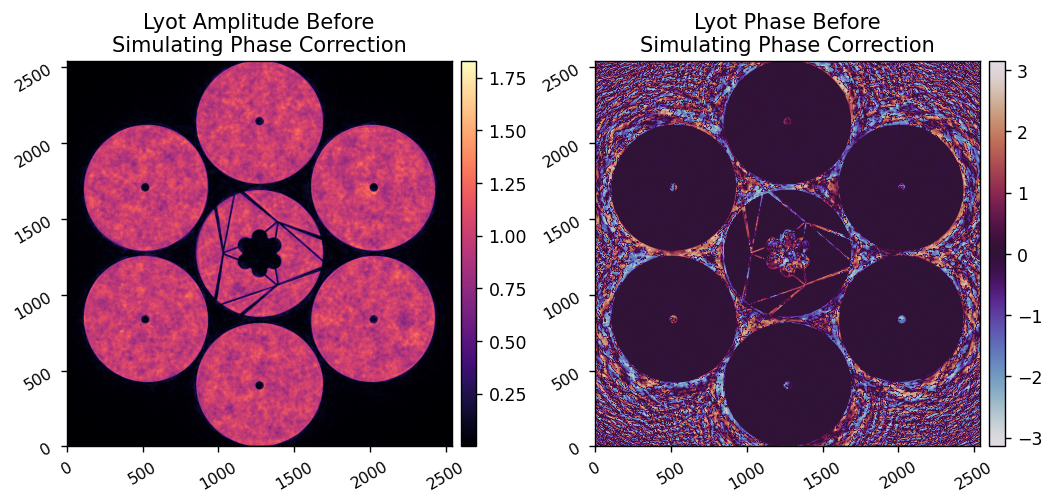

In [17]:
lyot_amp = utils.pad_or_crop(xp.abs(lyot_wf), model.npix)
lyot_phs = utils.pad_or_crop(xp.angle(lyot_wf), model.npix)

imshow2(lyot_amp, lyot_phs, 
        'Lyot Amplitude Before\nSimulating Phase Correction',
        'Lyot Phase Before\nSimulating Phase Correction',
        cmap2='twilight')

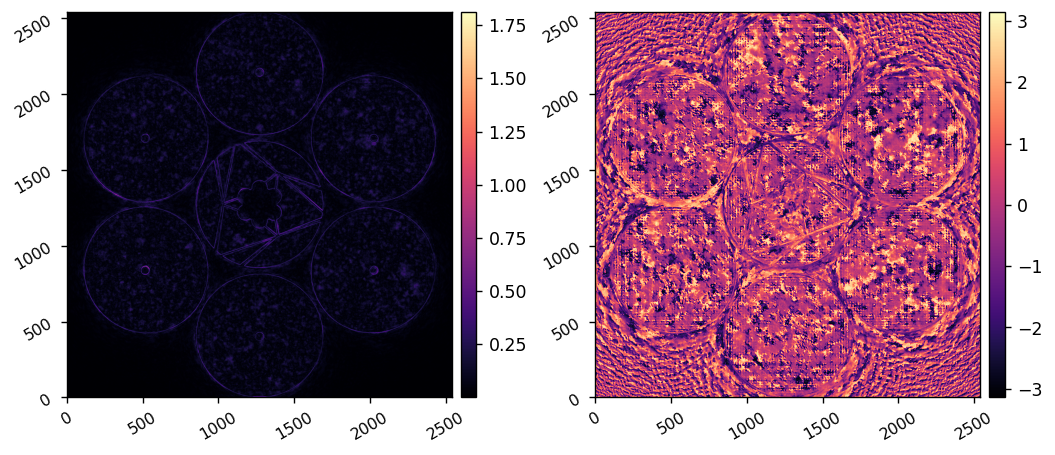

In [18]:
ideal_coro = lyot_wf - utils.pad_or_crop(model.PUPIL.amplitude, model.N)*xp.sum(lyot_wf*utils.pad_or_crop(model.PUPIL.amplitude, model.N))/xp.sum(model.PUPIL.amplitude*model.PUPIL.amplitude)
imshow2(xp.abs(ideal_coro), xp.angle(ideal_coro), npix=model.npix)

In [19]:
# apodizer_pixelscale = apodizer_pupil_diam/(model.npix*u.pix)
# apodizer = poppy.ArrayOpticalElement(transmission=xp.abs(ideal_coro), 
#                                      opd=xp.angle(ideal_coro)*model.wavelength.to_value(u.m)/(2*np.pi),
#                                      pixelscale=apodizer_pixelscale)

lyot_pixelscale = lyot_pupil_diam/(model.npix*u.pix)
LYOT = poppy.ArrayOpticalElement(transmission=xp.abs(ideal_coro), 
                                     opd=xp.angle(ideal_coro)*model.wavelength.to_value(u.m)/(2*np.pi),
                                     pixelscale=lyot_pixelscale)

In [20]:
reload(gmagaox)
model = gmagaox.MODEL(npix=2540, oversample=8192/2540)
model.use_opds = True
model.use_dm_surfaces = True

model.use_lyot_opd = True
model.LYOT_WFE = LYOT_WFE

# model.APODIZER = None
model.LYOT = None
raw_fp_wf = utils.pad_or_crop(model.calc_wf(), npsf)

model.Imax_ref = xp.max(xp.abs(raw_fp_wf)**2)
# model.APODIZER = apodizer
model.LYOT = LYOT
ideal_coro_fp_wf = utils.pad_or_crop(model.calc_wf(), npsf)

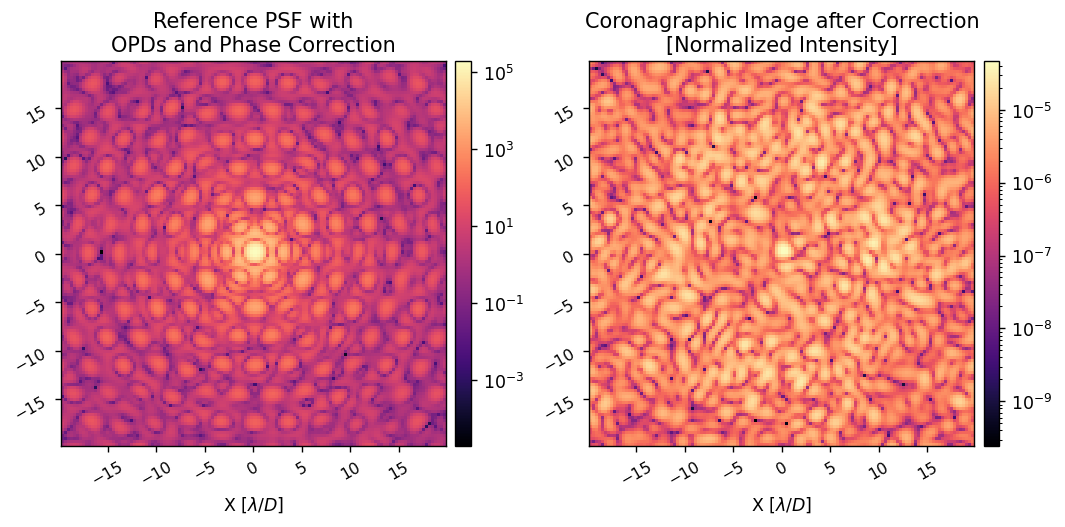

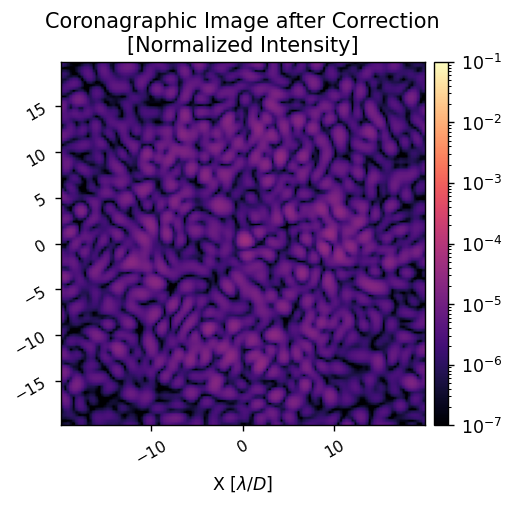

In [21]:
imshow2(xp.abs(raw_fp_wf)**2, xp.abs(ideal_coro_fp_wf)**2, 
        'Reference PSF with\nOPDs and Phase Correction', 'Coronagraphic Image after Correction\n[Normalized Intensity]',
        xlabel='X [$\lambda/D$]',
        npix=128, pxscl=1/model.oversample,
        lognorm=True)

imshow1(xp.abs(ideal_coro_fp_wf)**2, 'Coronagraphic Image after Correction\n[Normalized Intensity]',
        xlabel='X [$\lambda/D$]', pxscl=model.psf_pixelscale_lamD,
        lognorm=True, vmax=1e-1, vmin=1e-7)

In [11]:
!nvidia-smi


Tue Feb 27 15:19:09 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          Off |   00000000:25:00.0 Off |                    0 |
| N/A   34C    P0             62W /  300W |   34771MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

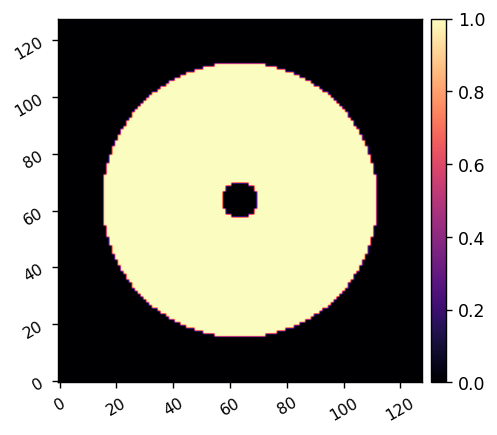

array(4.51129552e-06)

/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kianmilani/miniconda3/envs/gpu311env/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


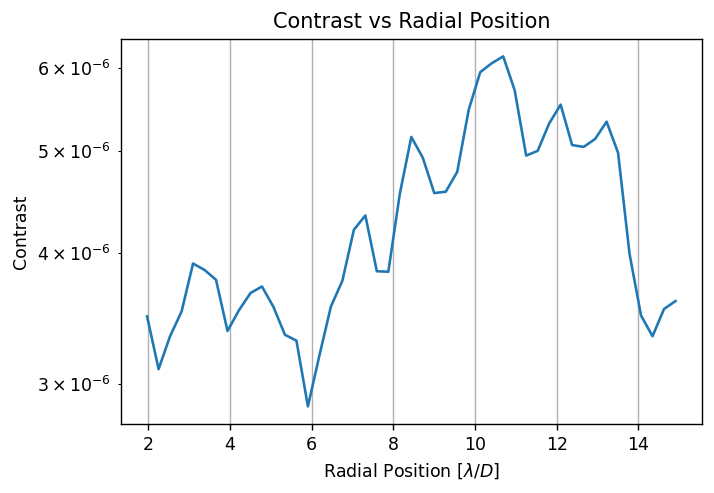

In [22]:
reload(utils)
iwa = 2
owa = 15
roi_mask = utils.create_annular_focal_plane_mask(model.psf_pixelscale_lamD, npsf, inner_radius=iwa, outer_radius=owa )
imshow1(roi_mask)

display(xp.mean((xp.abs(ideal_coro_fp_wf[roi_mask])**2)))

r_2, contrast_2 = utils.plot_radial_contrast(xp.abs(ideal_coro_fp_wf)**2, 
                                        roi_mask, 
                                        pixelscale=model.psf_pixelscale_lamD, 
                                        nbins=100,
                                        return_data=True)

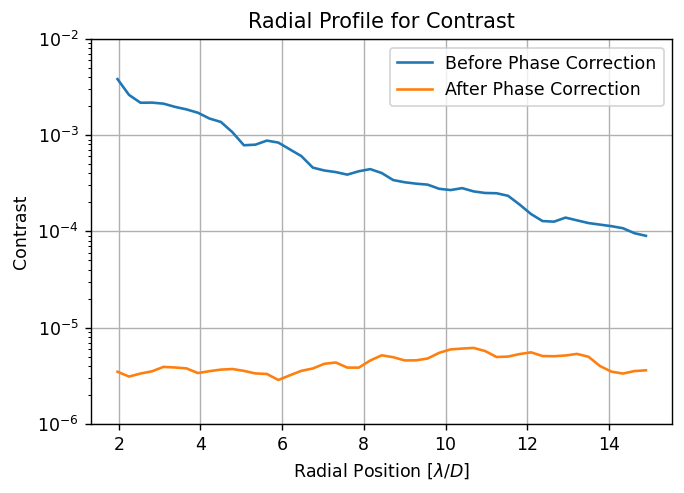

In [34]:
fig,ax = plt.subplots(nrows=1, ncols=1, dpi=125, figsize=(6,4))
ax.semilogy(r,contrast, label='Before Phase Correction')
ax.semilogy(r_2,contrast_2, label='After Phase Correction')
ax.set_xlabel('Radial Position [$\lambda/D$]')
ax.set_ylabel('Contrast')
ax.set_title('Radial Profile for Contrast')
ax.set_ylim([1e-6, 1e-2])
ax.legend()
ax.grid()
plt.close()
display(fig)